<a href="https://colab.research.google.com/github/hemadamostafa/Fire-smoke-Yolo-Detector/blob/main/Fire_and_Smoke_Detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip uninstall -y torch torchvision torchaudio
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

Found existing installation: torch 2.9.0+cu126
Uninstalling torch-2.9.0+cu126:
  Successfully uninstalled torch-2.9.0+cu126
Found existing installation: torchvision 0.24.0+cu126
Uninstalling torchvision-0.24.0+cu126:
  Successfully uninstalled torchvision-0.24.0+cu126
Found existing installation: torchaudio 2.9.0+cu126
Uninstalling torchaudio-2.9.0+cu126:
  Successfully uninstalled torchaudio-2.9.0+cu126
Looking in indexes: https://download.pytorch.org/whl/cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 780.4/780.4 MB 797.3 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 77.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 89.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 113.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 58.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 133.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/

In [1]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.device_count())

2.5.1+cu121
True
1


In [2]:
!pip install -q kagglehub ultralytics opencv-python matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 71.4 MB/s eta 0:00:00


In [3]:
import kagglehub

path = kagglehub.dataset_download(
    "sayedgamal99/smoke-fire-detection-yolo"
)

print("Dataset path:", path)


Using Colab cache for faster access to the 'smoke-fire-detection-yolo' dataset.
Dataset path: /kaggle/input/smoke-fire-detection-yolo


In [4]:
!ls $path


data  data.yaml


In [5]:
%%writefile fire.yaml
path: {PATH}

train: data/train/images
val: data/val/images
test: data/test/images

names:
  0: fire
  1: smoke


Writing fire.yaml


In [7]:
%%writefile fire.yaml
path: /root/.cache/kagglehub/datasets/sayedgamal99/smoke-fire-detection-yolo/versions/1

train: data/train/images
val: data/val/images
test: data/test/images

names:
  0: fire
  1: smoke


Overwriting fire.yaml


In [9]:
import os

labels_path = f"{path}/data/train/labels"
class_ids = set()

for fname in os.listdir(labels_path)[:50]:
    with open(os.path.join(labels_path, fname)) as f:
        for line in f:
            class_ids.add(int(line.split()[0]))

print("Class IDs found:", class_ids)


Class IDs found: {0, 1}


In [10]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [11]:
import os

save_dir = "/content/drive/MyDrive/YOLO_Models"
os.makedirs(save_dir, exist_ok=True)


In [16]:
import os

print(os.listdir("/content"))


['.config', 'fire.yaml', 'yolov8n.pt', 'drive', 'sample_data']


In [18]:
!pip install -q kagglehub
import kagglehub

In [26]:
import os

base = "/kaggle/input/smoke-fire-detection-yolo/data"
print("Train images exist?", os.path.exists(os.path.join(base, "train/images")))
print("Val images exist?", os.path.exists(os.path.join(base, "val/images")))
print("Test images exist?", os.path.exists(os.path.join(base, "test/images")))


Train images exist? True
Val images exist? True
Test images exist? True


In [25]:
import os

base_path = "/kaggle/input/smoke-fire-detection-yolo"
for root, dirs, files in os.walk(base_path):
    print("Root:", root)
    print("Dirs:", dirs)
    print("Files sample:", files[:5])
    print("-"*50)


Root: /kaggle/input/smoke-fire-detection-yolo
Dirs: ['data']
Files sample: ['data.yaml']
--------------------------------------------------
Root: /kaggle/input/smoke-fire-detection-yolo/data
Dirs: ['val', 'test', 'train']
Files sample: []
--------------------------------------------------
Root: /kaggle/input/smoke-fire-detection-yolo/data/val
Dirs: ['labels', 'images']
Files sample: []
--------------------------------------------------
Root: /kaggle/input/smoke-fire-detection-yolo/data/val/labels
Dirs: []
Files sample: ['PublicDataset01019.txt', 'WEB08651.txt', 'WEB07304.txt', 'WEB07388.txt', 'WEB02204.txt']
--------------------------------------------------
Root: /kaggle/input/smoke-fire-detection-yolo/data/val/images
Dirs: []
Files sample: ['AoF04660.jpg', 'WEB05194.jpg', 'AoF04762.jpg', 'WEB05365.jpg', 'AoF03726.jpg']
--------------------------------------------------
Root: /kaggle/input/smoke-fire-detection-yolo/data/test
Dirs: ['labels', 'images']
Files sample: []
----------------

In [27]:
from ultralytics import YOLO

model = YOLO("yolov8n.pt")  # nano model for speed

model.train(
    data="fire.yaml",
    epochs=1,
    imgsz=320,
    batch=64,
    workers=8,
    cache="ram",  # speeds up training
    device=0,     # GPU
    amp=True,     # mixed precision
    name="fire_final"
)


Ultralytics 8.3.241 🚀 Python-3.12.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=64, bgr=0.0, box=7.5, cache=ram, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=fire.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=1, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=320, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=fire_final, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f2984b9f5c0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

In [28]:
# Save the trained model
model_path = os.path.join(save_dir, "fire_final.pt")
model.save(model_path)
print("Model saved to:", model_path)


Model saved to: /content/drive/MyDrive/YOLO_Models/fire_final.pt


In [29]:
from ultralytics import YOLO

# Path to your trained model
model_path = "/content/drive/MyDrive/YOLO_Models/fire_final.pt"
model = YOLO(model_path)


image 1/1 /content/01212025-wildfire-colorado-malachi-brooks-unsplash-1500x844-1.jpeg: 192x320 4 fires, 34.9ms
Speed: 1.2ms preprocess, 34.9ms inference, 1.5ms postprocess per image at shape (1, 3, 192, 320)


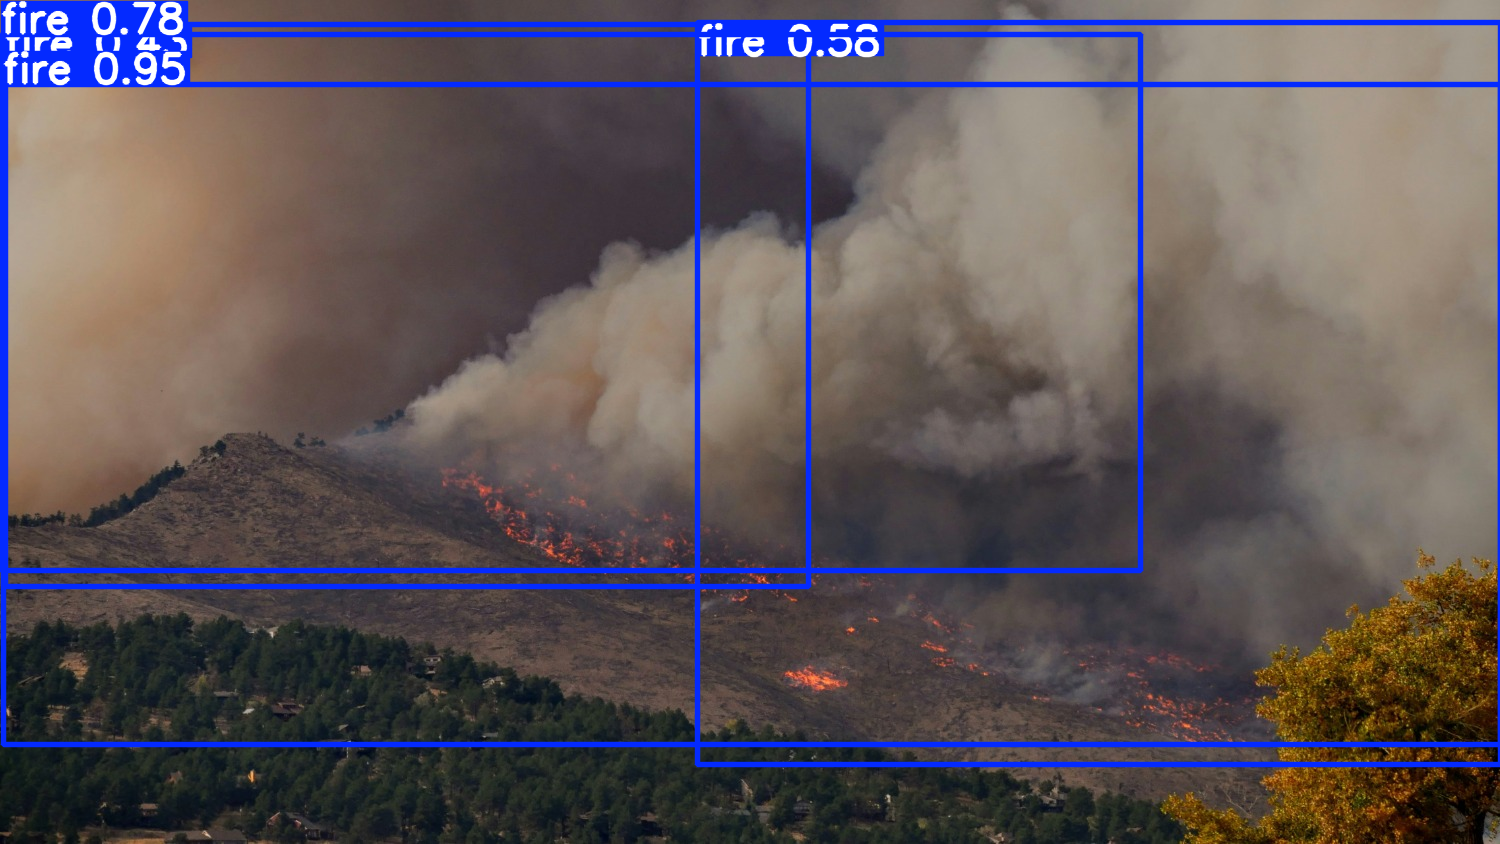

In [33]:
# Example image path
img_path = "https://cnr.ncsu.edu/news/wp-content/uploads/sites/10/2025/01/01212025-wildfire-colorado-malachi-brooks-unsplash-1500x844-1.jpeg"

# Run inference
results = model(img_path)

# Show results
results[0].show()  # This will display the image with bounding boxes


In [34]:
from ultralytics import YOLO

# Load your trained model (not the base yolov8n.pt)
model_path = "/content/drive/MyDrive/YOLO_Models/fire_final.pt"
model = YOLO(model_path)

In [35]:
model.train(
    data="fire.yaml",   # your dataset yaml
    epochs=10,          # total epochs to train (Colab can handle 5-20 for fast iteration)
    imgsz=320,          # keep small for faster training
    batch=64,           # bigger if GPU memory allows
    workers=8,          # data loading threads
    cache="ram",        # very fast if dataset fits in RAM
    mosaic=0.0,         # disable heavy augmentation early
    close_mosaic=0,     # fully disable mosaic
    amp=True,           # mixed precision for GPU speed
    device=0,           # GPU
    pretrained=True,    # keep learned weights
    name="fire_finetune", # folder name for new run
    exist_ok=True       # overwrite if folder exists
)


Ultralytics 8.3.241 🚀 Python-3.12.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=64, bgr=0.0, box=7.5, cache=ram, cfg=None, classes=None, close_mosaic=0, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=fire.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=320, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=/content/drive/MyDrive/YOLO_Models/fire_final.pt, momentum=0.937, mosaic=0.0, multi_scale=False, name=fire_finetune, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f2984ca7aa0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

In [36]:
from ultralytics import YOLO
import shutil
import os

# Load your latest trained model (or keep the model object in memory)
model_path = "runs/detect/fire_finetune/weights/best.pt"  # path of the trained model
model = YOLO(model_path)

# Define your new save path on Google Drive
save_dir = "/content/drive/MyDrive/YOLO_Models"
os.makedirs(save_dir, exist_ok=True)
new_model_path = os.path.join(save_dir, "fire_finetune_v2.pt")

# Save the model
shutil.copy(model_path, new_model_path)
print(f"Model saved to: {new_model_path}")


Model saved to: /content/drive/MyDrive/YOLO_Models/fire_finetune_v2.pt


In [39]:
from ultralytics import YOLO

# Load your trained model
model = YOLO("/content/drive/MyDrive/YOLO_Models/fire_finetune_v2.pt")

# Run validation
results = model.val(data="fire.yaml", batch=16, imgsz=320)

# Summary table
results.summary()

# Metrics per class
print("mAP50 per class:", results.maps)   # mAP50
print("Precision per class:", results.box.p)  # precision
print("Recall per class:", results.box.r)     # recall

# Optional: all detailed metrics in a dict
print("Detailed results dict:", results.results_dict)


Ultralytics 8.3.241 🚀 Python-3.12.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 23.2±17.0 MB/s, size: 122.3 KB)
val: Scanning /kaggle/input/smoke-fire-detection-yolo/data/val/labels... 3094 images, 1375 backgrounds, 5 corrupt: 100% ━━━━━━━━━━━━ 3099/3099 110.5it/s 28.1s
val: /kaggle/input/smoke-fire-detection-yolo/data/val/images/WEB07535.jpg: ignoring corrupt image/label: [Errno 30] Read-only file system: '/kaggle/input/smoke-fire-detection-yolo/data/val/images/WEB07535.jpg'
val: /kaggle/input/smoke-fire-detection-yolo/data/val/images/WEB07536.jpg: ignoring corrupt image/label: [Errno 30] Read-only file system: '/kaggle/input/smoke-fire-detection-yolo/data/val/images/WEB07536.jpg'
val: /kaggle/input/smoke-fire-detection-yolo/data/val/images/WEB07539.jpg: ignoring corrupt image/label: [Errno 30] Read-only file system: '/kaggle/input/smoke-fire-detection-y